In [1]:
import torch
import triton
import triton.language as tl

In [2]:
def naive_softmax(x: torch.Tensor):
    max_per_row = x.max(dim=-1, keepdim=True)[0] # bs, 1
    x = x - max_per_row
    numerator = x.exp()
    denominator = numerator.sum(dim=-1, keepdim=True) # bs, 1
    return numerator / denominator


In [3]:
@triton.jit
def softmax_kernel(x_ptr, out_ptr, n_cols: int, block_size: tl.constexpr):
    # 1. figure our coordinates in the 1D grid
    pid = tl.program_id(axis=0)

    # 2. figure out offsets to elements based on coordinates
    # each program processes entire row. block_size is next power of two
    # greater than n_cols
    col_offsets = tl.arange(0, block_size)
    offsets = pid * n_cols + col_offsets

    # 3. create mask since the block_size may be greater
    # than n_cols. see the comment in the wapper function
    # that calls this kernel
    mask = col_offsets < n_cols

    # since the softmax is 1 to 1 we read from same offsets
    # and write to the same offsets
    x_ptrs = x_ptr + offsets
    out_ptrs = out_ptr + offsets

    # load this row from global memory to SRAM
    row = tl.load(x_ptrs, mask, other=-float('inf'))

    # softmax implementation
    # subtract max. value of the row for numerical stability
    row = row - tl.max(row, axis=0)
    numerator = tl.exp(row)
    denominator = tl.sum(numerator, axis=0)
    output = numerator / denominator
    tl.store(out_ptrs, output, mask=mask)

    
    

def softmax(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda, "x must be in cuda"
    assert x.is_contiguous(), "x must be contiguous"
    assert x.ndim == 2, f"x should be 2D but got {x.ndim}"

    # create an output tensor with same shape as x
    output = torch.empty_like(x)

    n_rows, n_cols = x.shape

    # each program will process the entire row so
    # block size ideally should be same as number of column.
    # However, in triton, each block must have power of two
    # number of elements, so set the block size just enough to cover
    # all column and also be a power of two.
    # https://triton-lang.org/main/getting-started/tutorials/02-fused-softmax.html
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # our launch grid will be 1D where each program
    # will operate on one row of the input tensor
    grid = (
        n_rows,
    )

    softmax_kernel[grid](x, output, n_cols=n_cols, block_size=BLOCK_SIZE)
    return output

In [4]:
x = torch.rand(size=(3, 9), device='cuda')

torch_output = torch.softmax(x, dim=1) # same as torch.nn.functional.softmax
naive_output = naive_softmax(x)
our_output = softmax(x)

print(f"Same as torch: naive={torch.allclose(torch_output, naive_output)}. our={torch.allclose(torch_output, our_output)}.")
print(f"Torch softmax:\n{torch_output}")
print(f"Naive softmax:\n{naive_output}")
print(f"Our softmax:\n{our_output}")

Same as torch: naive=True. our=True.
Torch softmax:
tensor([[0.1189, 0.1424, 0.0785, 0.1339, 0.0821, 0.1762, 0.1011, 0.0762, 0.0906],
        [0.1097, 0.1890, 0.0867, 0.0760, 0.0979, 0.1678, 0.0883, 0.0866, 0.0978],
        [0.0963, 0.0650, 0.1171, 0.0733, 0.1078, 0.1292, 0.1334, 0.1584, 0.1195]],
       device='cuda:0')
Naive softmax:
tensor([[0.1189, 0.1424, 0.0785, 0.1339, 0.0821, 0.1762, 0.1011, 0.0762, 0.0906],
        [0.1097, 0.1890, 0.0867, 0.0760, 0.0979, 0.1678, 0.0883, 0.0866, 0.0978],
        [0.0963, 0.0650, 0.1171, 0.0733, 0.1078, 0.1292, 0.1334, 0.1584, 0.1195]],
       device='cuda:0')
Our softmax:
tensor([[0.1189, 0.1424, 0.0785, 0.1339, 0.0821, 0.1762, 0.1011, 0.0762, 0.0906],
        [0.1097, 0.1890, 0.0867, 0.0760, 0.0979, 0.1678, 0.0883, 0.0866, 0.0978],
        [0.0963, 0.0650, 0.1171, 0.0733, 0.1078, 0.1292, 0.1334, 0.1584, 0.1195]],
       device='cuda:0')


In [5]:
# something big
x = torch.rand(size=(1024, 768), device='cuda')

torch_output = torch.softmax(x, dim=1) # same as torch.nn.functional.softmax
naive_output = naive_softmax(x)
our_output = softmax(x)

print(f"Same as torch: naive={torch.allclose(torch_output, naive_output)}. our={torch.allclose(torch_output, our_output)}.")

Same as torch: naive=True. our=True.


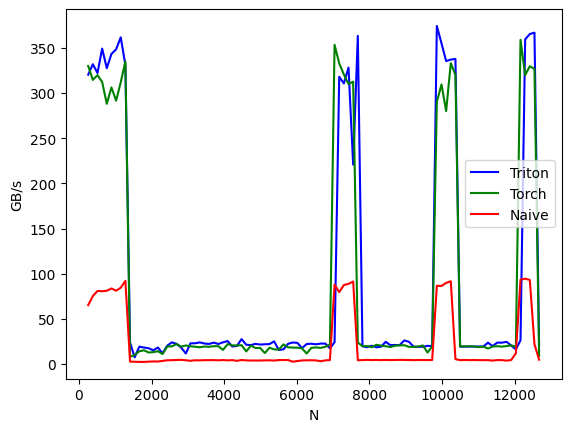

softmax-performance:
          N      Triton       Torch      Naive
0     256.0  320.223082  329.852348  65.269862
1     384.0  331.798372  314.453737  75.207775
2     512.0  322.074898  319.776297  80.940412
3     640.0  349.129652  312.240648  80.622386
4     768.0  327.397522  287.971575  81.148166
5     896.0  343.189767  306.133242  83.676331
6    1024.0  348.253084  291.524387  81.185343
7    1152.0  361.560581  311.778843  84.485019
8    1280.0  330.823510  335.035294  92.125812
9    1408.0   23.844772    7.928926   2.740961
10   1536.0    7.404709   10.262159   2.585373
11   1664.0   19.310337   14.178381   2.430335
12   1792.0   18.296614   15.264337   2.400680
13   1920.0   17.533514   12.859407   2.738488
14   2048.0   15.270673   13.193417   2.929152
15   2176.0   18.338583   14.290113   2.867230
16   2304.0   11.898235   11.094820   3.509536
17   2432.0   20.392844   19.561995   4.240551
18   2560.0   24.041585   19.595991   4.341315
19   2688.0   22.378047   22.143628   4

In [6]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()

torch.cuda.empty_cache()

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, dim=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)